In [94]:
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt

In [ ]:
# data from here https://www.kaggle.com/kasikrit/att-database-of-faces/code

In [31]:
def read_image(filename):
    im = Image.open(filename)
    return np.array(im)

In [22]:
img = read_image('archive/s1/1.pgm')
img.shape

(112, 92)

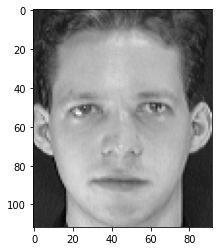

In [30]:
plt.imshow(img, cmap='gray')

In [37]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('archive/s' + str(1) + '/' + str(1) + '.pgm')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('archive/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm')
            img2 = read_image('archive/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('archive/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm')
            img2 = read_image('archive/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [38]:
X, Y = get_data(size, total_sample_size)

In [39]:
X.shape, Y.shape

((20000, 2, 1, 56, 46), (20000, 1))

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [43]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [45]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

/home/sidorkoda/workspace/study/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 56, 46..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()
/home/sidorkoda/workspace/study/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_first")`
/home/sidorkoda/workspace/study/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [46]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [49]:
epochs = 13
rms = RMSprop()

model = Model(input=[img_a, img_b], output=distance)

/home/sidorkoda/workspace/study/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  after removing the cwd from sys.path.


In [51]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=rms)

In [52]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, nb_epoch=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/sidorkoda/workspace/study/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 11250 samples, validate on 3750 samples
Epoch 1/13
 - 3s - loss: 0.2616 - val_loss: 0.2865
Epoch 2/13
 - 1s - loss: 0.1708 - val_loss: 0.2178
Epoch 3/13
 - 1s - loss: 0.1351 - val_loss: 0.1862
Epoch 4/13
 - 1s - loss: 0.1077 - val_loss: 0.1512
Epoch 5/13
 - 1s - loss: 0.0887 - val_loss: 0.1379
Epoch 6/13
 - 1s - loss: 0.0731 - val_loss: 0.1132
Epoch 7/13
 - 1s - loss: 0.0644 - val_loss: 0.0904
Epoch 8/13
 - 1s - loss: 0.0585 - val_loss: 0.0663
Epoch 9/13
 - 1s - loss: 0.0532 - val_loss: 0.0589
Epoch 10/13
 - 1s - loss: 0.0471 - val_loss: 0.0498
Epoch 11/13
 - 1s - loss: 0.0434 - val_loss: 0.0445
Epoch 12/13
 - 1s - loss: 0.0399 - val_loss: 0.0425
Epoch 13/13
 - 1s - loss: 0.0367 - val_loss: 0.0331


In [53]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [82]:
from sklearn.metrics import log_loss, accuracy_score

def compute_accuracy(predictions, labels):
    return accuracy_score(predictions, labels)

In [93]:
np.min(pred), np.max(pred)

(0.0053150905, 1.9844587)

In [90]:
pred1 = (2 - pred) / 2

In [91]:
for i in range(pred1.shape[0]):
    print(y_test[i], pred1[i])

[1.] [0.9782035]
[1.] [0.98466045]
[0.] [0.5879935]
[1.] [0.9610839]
[0.] [0.4757802]
[1.] [0.9491182]
[1.] [0.97614837]
[1.] [0.9514463]
[0.] [0.21455103]
[0.] [0.7544908]
[0.] [0.12933773]
[1.] [0.98554426]
[0.] [0.6081791]
[1.] [0.9808408]
[0.] [0.5995021]
[1.] [0.9618384]
[0.] [0.51615167]
[1.] [0.9342204]
[0.] [0.3486535]
[1.] [0.9860152]
[0.] [0.61731493]
[0.] [0.4561491]
[1.] [0.95005685]
[0.] [0.9775876]
[0.] [0.77576995]
[1.] [0.9328973]
[1.] [0.93222606]
[1.] [0.98116076]
[0.] [0.21455103]
[0.] [0.47598982]
[1.] [0.9458933]
[0.] [0.51645374]
[0.] [0.49624217]
[1.] [0.9566751]
[0.] [0.28848237]
[1.] [0.97917455]
[0.] [0.3213902]
[0.] [0.39908224]
[0.] [0.5974424]
[1.] [0.94173074]
[0.] [0.38661838]
[0.] [0.64964175]
[1.] [0.93506217]
[1.] [0.957906]
[1.] [0.97014827]
[1.] [0.9592455]
[1.] [0.8895153]
[0.] [0.8236238]
[1.] [0.96616364]
[0.] [0.45571828]
[0.] [0.59695876]
[1.] [0.98407495]
[0.] [0.7120209]
[1.] [0.93377507]
[0.] [0.42076463]
[1.] [0.8889406]
[0.] [0.4488477]
[0.

[0.] [0.4134782]
[1.] [0.93835837]
[1.] [0.95673907]
[1.] [0.93090516]
[0.] [0.39819747]
[1.] [0.93661255]
[0.] [0.6176398]
[1.] [0.9560716]
[0.] [0.7347744]
[1.] [0.97989166]
[1.] [0.9633403]
[0.] [0.5172423]
[1.] [0.968289]
[1.] [0.9743112]
[1.] [0.9732087]
[1.] [0.9421716]
[1.] [0.958066]
[0.] [0.25320226]
[0.] [0.8534998]
[0.] [0.49264342]
[0.] [0.5048564]
[0.] [0.63959026]
[0.] [0.60484886]
[1.] [0.97026896]
[1.] [0.9821248]
[0.] [0.736789]
[0.] [0.4669996]
[1.] [0.9596688]
[1.] [0.9589073]
[0.] [0.5085139]
[1.] [0.9608272]
[1.] [0.9521143]
[1.] [0.9781917]
[0.] [0.5981166]
[0.] [0.5789522]
[0.] [0.54420173]
[0.] [0.38829094]
[0.] [0.16514242]
[0.] [0.76559937]
[1.] [0.9530295]
[1.] [0.9523906]
[0.] [0.41702503]
[0.] [0.63666505]
[0.] [0.2999273]
[1.] [0.978269]
[0.] [0.41785347]
[0.] [0.5656203]
[0.] [0.5216563]
[1.] [0.95841825]
[0.] [0.16016513]
[0.] [0.4520194]
[0.] [0.80308604]
[1.] [0.9452775]
[0.] [0.43268818]
[0.] [0.25865746]
[1.] [0.9053218]
[0.] [0.5118742]
[1.] [0.9588

[1.] [0.97553045]
[1.] [0.964632]
[0.] [0.5390569]
[0.] [0.61960423]
[1.] [0.9639544]
[1.] [0.94831276]
[0.] [0.5236176]
[0.] [0.64181864]
[1.] [0.9632536]
[0.] [0.82842034]
[1.] [0.9622105]
[1.] [0.97570693]
[1.] [0.9224516]
[1.] [0.9737282]
[0.] [0.3687384]
[1.] [0.9650885]
[0.] [0.25435418]
[0.] [0.46285635]
[1.] [0.9772365]
[0.] [0.39214396]
[0.] [0.47145838]
[1.] [0.9899171]
[0.] [0.6190679]
[0.] [0.46215385]
[1.] [0.974517]
[1.] [0.9670716]
[1.] [0.9451387]
[0.] [0.14100105]
[0.] [0.5055693]
[0.] [0.35741663]
[1.] [0.9723635]
[0.] [0.18749589]
[0.] [0.8574013]
[1.] [0.9725685]
[1.] [0.9423475]
[1.] [0.9569891]
[0.] [0.4178213]
[1.] [0.97026896]
[0.] [0.577832]
[0.] [0.4829226]
[1.] [0.9757279]
[0.] [0.58978283]
[0.] [0.35831332]
[0.] [0.5050746]
[1.] [0.91587245]
[1.] [0.95745456]
[1.] [0.98099923]
[1.] [0.8995237]
[1.] [0.9622539]
[1.] [0.9408572]
[0.] [0.5762025]
[1.] [0.96558553]
[1.] [0.9592455]
[0.] [0.2941097]
[0.] [0.7608322]
[0.] [0.27322572]
[0.] [0.5177916]
[0.] [0.5028

[0.] [0.38200635]
[0.] [0.5647242]
[1.] [0.9562054]
[1.] [0.9934664]
[0.] [0.2744673]
[0.] [0.6396801]
[0.] [0.53724957]
[0.] [0.6475104]
[1.] [0.97493476]
[1.] [0.963364]
[1.] [0.9772159]
[0.] [0.46279007]
[0.] [0.5770185]
[1.] [0.97760206]
[0.] [0.60896915]
[1.] [0.95541734]
[1.] [0.971901]
[1.] [0.9621561]
[0.] [0.23201263]
[1.] [0.9709433]
[1.] [0.9256041]
[0.] [0.4148056]
[1.] [0.9560633]
[1.] [0.98599094]
[1.] [0.93258286]
[1.] [0.9717999]
[0.] [0.2287299]
[1.] [0.971394]
[0.] [0.38972878]
[1.] [0.92441326]
[1.] [0.98927474]
[0.] [0.2480517]
[0.] [0.5434631]
[1.] [0.9834908]
[1.] [0.9350386]
[1.] [0.97534645]
[1.] [0.9757279]
[1.] [0.97005475]
[1.] [0.9688463]
[1.] [0.9633403]
[1.] [0.96930957]
[1.] [0.9754753]
[1.] [0.98595554]
[1.] [0.9639544]
[0.] [0.7616237]
[0.] [0.47848052]
[0.] [0.48236728]
[1.] [0.97598404]
[0.] [0.45512015]
[0.] [0.4189456]
[0.] [0.39510232]
[1.] [0.9706862]
[1.] [0.95191664]
[1.] [0.94457996]
[1.] [0.98226184]
[1.] [0.96276]
[0.] [0.46684754]
[1.] [0.96

[1.] [0.97653973]
[1.] [0.93235177]
[0.] [0.41515255]
[1.] [0.9322388]
[0.] [0.5805553]
[0.] [0.6107002]
[1.] [0.98797077]
[1.] [0.9821248]
[0.] [0.32243365]
[1.] [0.98179877]
[0.] [0.1927365]
[0.] [0.29491633]
[0.] [0.48866343]
[1.] [0.97059226]
[0.] [0.592203]
[1.] [0.9899171]
[0.] [0.5007994]
[0.] [0.48544306]
[0.] [0.34682214]
[0.] [0.23545563]
[0.] [0.5375941]
[1.] [0.96097136]
[0.] [0.547732]
[0.] [0.43028188]
[0.] [0.36638337]
[0.] [0.3178662]
[0.] [0.3452257]
[1.] [0.92441326]
[0.] [0.38400763]
[1.] [0.90991175]
[0.] [0.39785463]
[1.] [0.9704762]
[0.] [0.3043949]
[1.] [0.9669831]
[0.] [0.47439456]
[0.] [0.40650833]
[0.] [0.44077688]
[1.] [0.95904124]
[1.] [0.9738299]
[0.] [0.8081366]
[1.] [0.9702126]
[0.] [0.5562973]
[1.] [0.9837026]
[1.] [0.9590515]
[1.] [0.9756149]
[1.] [0.9649625]
[0.] [0.3668822]
[1.] [0.99133164]
[1.] [0.9855465]
[0.] [0.6847349]
[0.] [0.32198322]
[1.] [0.9883402]
[1.] [0.99028575]
[1.] [0.97534806]
[0.] [0.34926295]
[1.] [0.9452033]
[0.] [0.6588541]
[1.] 

[1.] [0.9468004]
[1.] [0.97819936]
[0.] [0.3357249]
[1.] [0.96095103]
[0.] [0.44277096]
[1.] [0.9860505]
[1.] [0.92296886]
[1.] [0.95929044]
[0.] [0.53600544]
[0.] [0.16894144]
[0.] [0.6835613]
[1.] [0.973836]
[0.] [0.6299858]
[1.] [0.91617334]
[0.] [0.51683164]
[1.] [0.92325413]
[1.] [0.9581825]
[1.] [0.94549775]
[1.] [0.97586244]
[0.] [0.6451781]
[0.] [0.42706454]
[0.] [0.49307793]
[0.] [0.3093652]
[1.] [0.96541774]
[1.] [0.96702975]
[1.] [0.88370293]
[1.] [0.91617334]
[1.] [0.93537784]
[1.] [0.92272264]
[1.] [0.973186]
[0.] [0.5549575]
[0.] [0.20534408]
[0.] [0.3651027]
[0.] [0.30944538]
[0.] [0.6527774]
[1.] [0.87335676]
[0.] [0.38091642]
[1.] [0.98782927]
[1.] [0.9423161]
[0.] [0.51712906]
[0.] [0.6051661]
[0.] [0.6135615]
[1.] [0.96760106]
[0.] [0.38446885]
[0.] [0.7520791]
[1.] [0.9271601]
[1.] [0.96068543]
[1.] [0.95118815]
[0.] [0.8402165]
[0.] [0.19298697]
[0.] [0.70667624]
[1.] [0.91655135]
[1.] [0.951341]
[0.] [0.36037683]
[0.] [0.48633796]
[0.] [0.5613346]
[1.] [0.98245656

[1.] [0.94341743]
[0.] [0.39349568]
[0.] [0.33209497]
[0.] [0.4859779]
[1.] [0.9426716]
[0.] [0.5515633]
[0.] [0.42449415]
[0.] [0.03654087]
[1.] [0.94119936]
[0.] [0.32108682]
[1.] [0.9656585]
[1.] [0.96315265]
[0.] [0.5264596]
[1.] [0.9475538]
[1.] [0.9538546]
[1.] [0.9669246]
[1.] [0.9798182]
[1.] [0.962425]
[1.] [0.93649703]
[0.] [0.46735126]
[1.] [0.924932]
[0.] [0.5030965]
[1.] [0.9689129]
[1.] [0.8985228]
[0.] [0.9175747]
[0.] [0.50571597]
[1.] [0.9575789]
[0.] [0.4723683]
[0.] [0.2879169]
[1.] [0.9456659]
[0.] [0.3927757]
[0.] [0.72839177]
[0.] [0.60963327]
[1.] [0.9891255]
[1.] [0.98407495]
[1.] [0.92581946]
[0.] [0.65429336]
[0.] [0.41282642]
[0.] [0.28543073]
[1.] [0.9824211]
[0.] [0.29157966]
[0.] [0.42376488]
[1.] [0.93291146]
[1.] [0.97345597]
[1.] [0.98936677]
[1.] [0.8963082]
[0.] [0.21481884]
[1.] [0.97653973]
[0.] [0.3143031]
[1.] [0.979394]
[0.] [0.28532326]
[1.] [0.95407]
[1.] [0.9417499]
[0.] [0.11893052]
[1.] [0.979542]
[1.] [0.98659545]
[1.] [0.94341743]
[0.] [0.

In [92]:
compute_accuracy(np.squeeze(pred1) > 0.5, np.squeeze(y_test))

0.7674